chebyshev.ipynb was getting too big, so we're starting a new one

In [1]:
from sympy import init_session
init_session()
from mpmath import mpf
%matplotlib inline

IPython console for SymPy 1.0.1.dev (Python 3.5.2-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/dev



Now we try to mechanise the CRAM process

In [2]:
def bisect_roots(expr, bounds, eps=1e-7, division_cutoff=30, solver='bisect', **kwargs):
    """
    Numerically find all the roots of expr in bounds via bisection
    
    division_cutoff is the fraction of bounds to check for roots. 
    One should expect the roots to be no more than |bounds|/division_cutoff apart.
    """
    roots = []
    intervals = [bounds]
    var = expr.free_symbols.pop()
    N = 0
    while intervals:
        N += 1
        #print(intervals)
        b = intervals.pop()
        try:
            root = nsolve(expr, b, solver=solver, **kwargs)
        except ValueError:
            # No root found
            if (b[1] - b[0]) > (bounds[1] - bounds[0])/division_cutoff and sign(expr.evalf(subs={var: b[0]})) == sign(expr.evalf(subs={var: b[1]})):
                # The bisect method will only work if the interval has alternate signs.
                # If not, it will miss 2 roots, so try again with split intervals.
                intervals.append([b[0], (b[0] + b[1])/2])
                intervals.append([(b[0] + b[1])/2, b[1]])
                continue
        else:
            if root not in roots:
                roots.append(root)
                intervals.append([b[0], root - eps])
                intervals.append([root + eps, b[1]])
    
    print(N)
    return sorted(roots)

bisect_roots(sin(x), [-10, 13])

115


In [3]:
def nsolve_intervals(expr, bounds, division=30, **kwargs):
    """
    Divide bounds into division intervals and nsolve in each one
    """
    roots = []
    L = bounds[1] - bounds[0]
    for i in range(division):
        interval = [bounds[0] + i*L/division, bounds[0] + (i + 1)*L/division]
        try:
            root = nsolve(expr, interval, solver='bisect', **kwargs)
        except ValueError:
            continue
        else:
            roots.append(root)
            
    return roots
        
#nsolve_intervals(D, [-1, 0.99])

Iteration 0
sol {q1: -1.2113780527339829663720050640276110216097663989982877089246573959056257635727617952567834303786218085058337873678187384930031849, epsilon: -0.00097735555916870931377775973822218571926374214877893943567669936582713675276917283027325953409977920087904773344549565520594881463, q2: 0.49437363426005537647017346274301422921699776214736755755054784265619830646275073516398279513805238381121328364648529545772238403, p0: 0.60555330415346471429002177525295826772265439333840801624721545936922938266097925116837435197388967682554474206059402952133185927, p1: -1.3480395998868617696789279112931050803082966827084092652631144899025276862964072452194499033631251913101710815465165282222386292, p2: 0.74276288303822174395271351039765110991730604517556269014437772429634856878286742489970388369978362015941306823300302366773164935}
system.subs(sol) (-1.3480395998868617696789279112931050803082966827084092652631144899025276862964072452194499033631251913101710815465165282222386292*cos(3*pi/

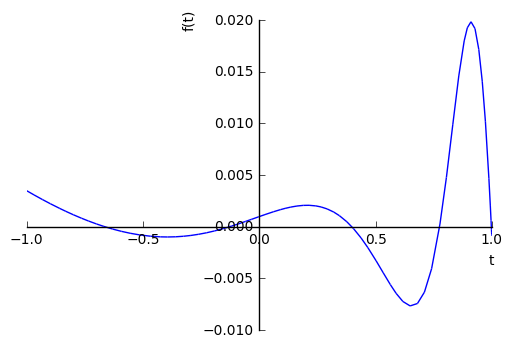

[-1, -0.395657914602797829570024389523550210357835735802793472002445723464508517771096512347816248096484806448994, 0.206032115429276304127674874362551480330450366196015295250799983140588697691180903896742583276257851613813, 0.655240044657463343209145243363071789315037260700559195250075200042502107132904900772925823289436324616510, 0.911026154275045005118547649206381784297371058339241059171840889712745696425177871843886389080590818542871, 1]
Evals [0.0034725654836155765706029957710571135345190105522356050146955756770519875857720077933651076377234730715114008956984065593960488876, -0.00099840506780781844495938247090386263663784881549779442695619102700148272839103973705032306781874995303035156465459511753967996543, 0.0020706431242257288610734017937419387681435466834731016683782321216255318784427607334676519619208150173813535793206931034278461360, -0.0076853207146970941425896565148187082144304613133223774481154989449340177864901072390848513963964474203503810223238977716504719918, 0.0198318

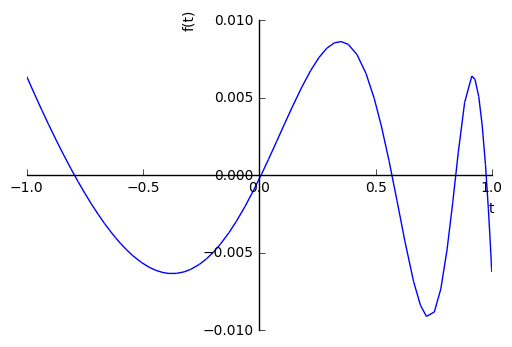

In [ ]:
from sympy.utilities.decorator import conserve_mpmath_dps

@conserve_mpmath_dps
def CRAM_exp2(loops=2):
    import mpmath
    prec = 128
    #mpmath.mp.dps = prec

    epsilon = symbols("epsilon")
    p0, p1, p2, q1, q2 = symbols("p0, p1, p2, q1, q2")
    i = symbols("i")
    
    r = (p0 + p1*t + p2*t**2)/(1 + q1*t + q2*t**2)
    E = exp(-(-t - 1)/(2*t - 2)) - r
    expr = E + (-1)**i*epsilon
    expr = expr*(1 + q1*t + q2*t**2)
    expr = simplify(expr)

    points = [chebyshevt_root(7, 6 - j) for j in range(1, 7)]
    for iteration in range(loops):
        print("Iteration", iteration)
        system = Tuple(*[expr.subs({i: j, t: points[j]}) for j in range(5)])
        system = system + Tuple(expr.replace(exp, lambda i: 0).subs({i: 5, t: 1}))
        #print(system)
        sol = dict(zip([p0, p1, p2, q1, q2, epsilon], nsolve(system, [p0, p1, p2, q1, q2, epsilon], [1, 1, 1, 1, 1, 0], prec=prec)))
        print('sol', sol)
        print('system.subs(sol)', system.subs(sol))
        D = diff(E.subs(sol), t)
        plot(E.subs(sol), (t, -1, 1))
        # More 9's here means more accuracy, but we can't use 1 because of the singularity
        points = [-1, *nsolve_intervals(D, [-1, 0.99], maxsteps=300, prec=prec), 1]# mpf('0.9999999999999999999999999999999999999999999999999999999999999999999999999999')]
        print(points)
        Evals = [E.evalf(prec, subs={**sol, t: point}) for point in points[:-1]] + [-r.evalf(prec, subs={**sol, t: 1})]
        print('Evals', Evals)
        print('max - min', max(map(abs, Evals)) - min(map(abs, Evals)))
        print('epsilon', sol[epsilon])
        assert len(points) == 6
    
    print(sol)
    sol = {i: Rational(str(sol[i])) for i in sol}
    print(sol)
    n, d = together(r.subs(sol).subs(t, (2*t - 1)/(2*t + 1))).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
    rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
    return rat_func.evalf(prec)

#D = CRAM_exp2()

rat_func = CRAM_exp2(8)
print(rat_func)
plot(rat_func - exp(-t), (t, 0, 100))

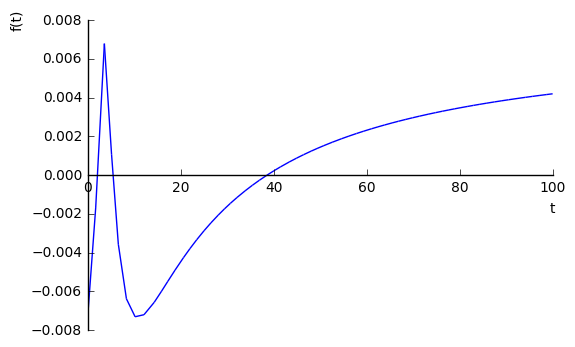

In [85]:
#correct_rat_func2 = (9.92641e-1 + -1.88332e-1*t + 4.21096e-3*t**2)/(1 + 6.69295e-1*t + 5.72258e-1*t**2)
#plot(correct_rat_func2 - exp(-t), (t, 0, 100))

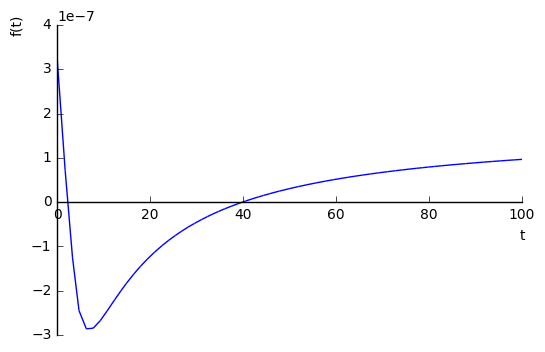

In [86]:
#plot(rat_func - correct_rat_func2, (t, 0, 100))

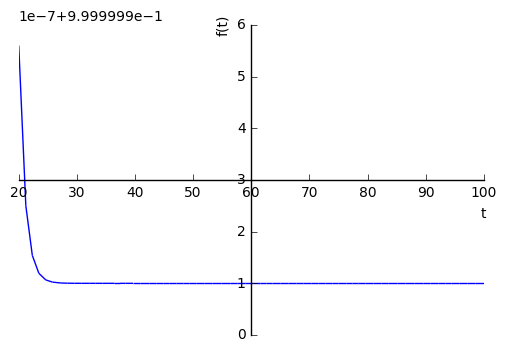

In [41]:
plot((correct_rat_func2 - exp(-t))/correct_rat_func2, (t, 20, 100))

In [5]:
nsolve(D, (-1, -0.39506511254484362 - 1e-20), solver='bisect', tol=1e-20)

mpf('-0.39506511254488194')

In [6]:
#import mpmath
#mpmath.findroot?

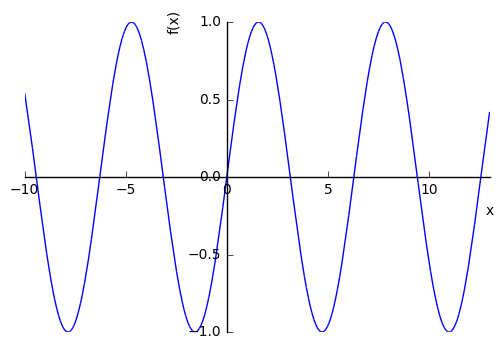

In [7]:
plot(sin(x), (x, -10, 13))

In [8]:
nsolve(sin(x), [-10, -0.1], solver='bisect')

mpf('-3.1415926535897932')

In [9]:
bisect_roots(D, [-1, 0.9], solver='bisect')

109


[mpf('-0.39506511254488194'),
 mpf('0.20691058995492143'),
 mpf('0.65489012733236148'),
 mpf('0.89772666518036129'),
 mpf('0.89772676518036132'),
 mpf('0.89772676518036132'),
 mpf('0.89772686518036127'),
 mpf('0.89772686518036127'),
 mpf('0.89772696518036121'),
 mpf('0.89772696518036121'),
 mpf('0.89772706518036116'),
 mpf('0.89772706518036116')]

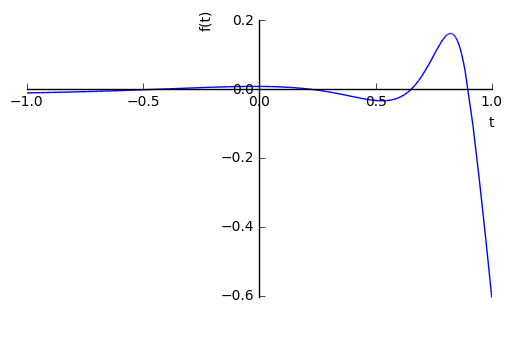

In [10]:
plot(D, (t, -1, 1))

In [11]:
nsolve(D, [mpf('0.2069106899549174') + 1e-4, 0.999], solver='ridder')

ValueError: Could not find root within given tolerance. (1.065e-06 > 2.1684e-19)
Try another starting point or tweak arguments.

In [ ]:
intervals = [[i/30, (i+1)/30] for i in range(-30, 29)]

In [ ]:
def catch_ValueError(f):
    try:
        return f()
    except ValueError:
        pass

In [ ]:
[catch_ValueError(lambda: nsolve(D, b, solver='bisect')) for b in intervals]

In [ ]:
sin(x).evalf(subs={x: mpf('9.9999999999999995e-8')})

In [12]:
nsolve(D, (-1, 0), solver='bisect')

mpf('-0.39506511254488194')

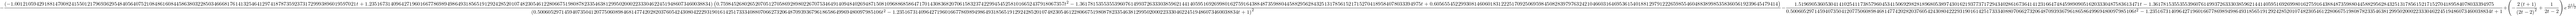

In [13]:
D

In [34]:
import mpmath
try:
    mpmath.mp.dps = 128
    print(nsolve(D, (-1, 0), solver='bisect', maxsteps=300))
finally:
    mpmath.mp.dps = 15

ValueError: Could not find root within given tolerance. (1.38725 > 1.40884e-132)
Try another starting point or tweak arguments.

In [30]:
chebyshevt(2, x)

In [91]:
0.9999999999999999

In [92]:
0.99999999999999999

In [106]:
exp(-(-t - 1)/(2*t - 2))

In [107]:
solve((0.57224957904836676579778131095824616229041363386436155632065723326613208320645433529158968043480368460271370103317310738469165646*t**2 + 0.66930154271086975944415360267931286108869186534800442869820775970713699218292282609079303557228276229468949430966691265928683428*t + 1.0))

In [111]:
[1, 2, 3][:-1]

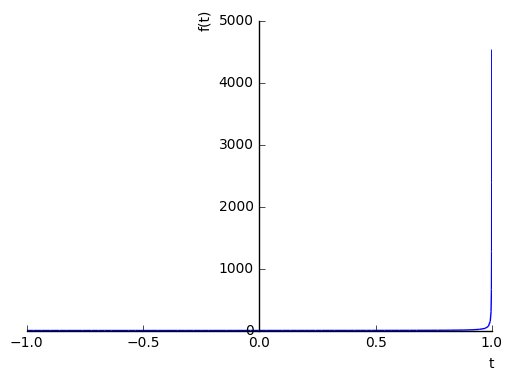

In [116]:
plot((t + 1)/(t - 1)*(-1/2), (t, -1, 1))

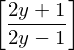

In [120]:
solve(y - -(-t - 1)/(2*t - 2), t)

In [124]:
exp(-(-t - 1)/(2*t - 2)).evalf(subs={t: 0})

In [128]:
len('42109959068982')

In [130]:
@conserve_mpmath_dps
def test_increased_dps():
    # Issue 8564
    import mpmath
    mpmath.mp.dps = 128
    x = Symbol('x')
    e1 = x**2 - pi
    q = nsolve(e1, x, 3.0)

    assert abs(sqrt(pi).evalf(128) - q) < 1e-128

test_increased_dps()

In [137]:
@conserve_mpmath_dps
def test_mpf_subs():
    import mpmath
    mpmath.mp.dps = 128
    a = mpf('1') + mpf('1e-100')
    print(a)
    print(x.subs(x, a))
    print(Float(a))

test_mpf_subs()

1.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
1.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000
1.00000000000000


In [144]:
@conserve_mpmath_dps
def test_increased_dps2():
    # Issue 8564
    import mpmath
    mpmath.mp.dps = 128
    x = Symbol('x')
    e1 = x**2 - pi
    q = nsolve(e1, x, 3.0)
    print((x**2).subs(x, q))
    print(pi.evalf(128))

test_increased_dps2()

3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446
3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446


In [159]:
p0, p1, p2, q1, q2, epsilon = symbols("p0, p1, p2, q1, q2, epsilon")
r = (p0 + p1*t + p2*t**2)/(1 + q1*t + q2*t**2)
mpf = lambda i: Float(i, 128)
sol = {q1: mpf('-1.1598158896958144389688907541448290768017556418690225475316113676987123000368036156835800708110657203943382445749046292411027838124'), epsilon: mpf('-0.0073586701695804955713909885597251540212160797660122172060482127633180200310633941837926800633336626154349676612971775593725674790502'), p1: mpf('-1.3420582608178928401767377898250826050312440510776128093723998679786607122879166676244905769597498693757444204486264349423147412592'), q2: mpf('0.54706937851182403348832181267224373295821044378627516587652817178767445252898045643900602804552389487580236216086250141313671452195'), p2: mpf('0.73617861351264467252445532341623038921509966014009367227031009417645097851179620934054146565716699654528814524660644163951335402577'), p0: mpf('0.6087293180014645115203537929174427433501475052521283394857491045045741371996335477254671722188240766010031663167379415577767292914')}
other_rat_func ="(0.0042109959068981902319228224147959051043334784348885130731594832554304543920692286150512328715813585751529478908147308247510818304*t**2 - 0.1883335019892743246297189560004799477752569428797900790843481507588522143198473107264222704579544281038255097909548061885535647*t + 0.99264132983041950442860901144027484597878392023398778279395178723668197996893660581620731993666633738456503233870282244062743252)/(0.57224957904836377040707255710162720198078512465710225748045909842276672878045476079146532782980255617241659394936652703249328588*t**2 + 0.66930154271087159949217750010925437712785181665997133501826390508750116474339450131113420220623360917322211168993495402213680723*t + 1.0)"

n, d = together(r.subs(sol).subs(t, (2*t - 1)/(2*t + 1))).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
print(rat_func)
print(other_rat_func)
del mpf

(0.0042109959068981903672474918875361551007743401128474766461802591015712655915560212085757577812298111403461332420727108940545962494*t**2 - 0.18833350198927433660307962375773654674462542624169163004230191709861650774462882479765838272526363158731185437928170659058040915*t + 0.9926413298304194180068495413519683855439395137082812516374575465853211659111912419679717799455724616744715155164834640408451293)/(0.57224957904836372570736532872030629677308743654023638843264990775530979197679586149353512762232398453528690780049165209508067807*t**2 + 0.66930154271087160162786406975682578159531634634707357772167429073040499365644728839234121616979336460323388632486469784004599072*t + 1.0)
(0.0042109959068981902319228224147959051043334784348885130731594832554304543920692286150512328715813585751529478908147308247510818304*t**2 - 0.1883335019892743246297189560004799477752569428797900790843481507588522143198473107264222704579544281038255097909548061885535647*t + 0.9926413298304195044286090114402748459